# Research Workflow

This notebook demonstrates the research [workflow](https://langchain-ai.github.io/langgraph/tutorials/workflows/) that creates comprehensive reports through a series of focused steps. The system:

1. Uses a **graph workflow** with specialized nodes for each report creation stage
2. Enables user **feedback and approval** at critical planning points 
3. Produces a well-structured report with introduction, researched body sections, and conclusion

## From repo 

In [8]:
%cd ..
%load_ext autoreload
%autoreload 2

g:\MyProjects\open_deep_research
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## From package 

In [15]:
! pip install -U -q open-deep-research


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
! pip install -U -q nest-asyncio

# Compile the Graph-Based Research Workflow

The next step is to compile the LangGraph workflow that orchestrates the report creation process. This defines the sequence of operations and decision points in the research pipeline.

In [7]:
# Import required modules and initialize the builder from open_deep_research
import uuid 
import os, getpass
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from open_deep_research.graph import builder

0.0.15


In [9]:
# Create a memory-based checkpointer and compile the graph
# This enables state persistence and tracking throughout the workflow execution

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

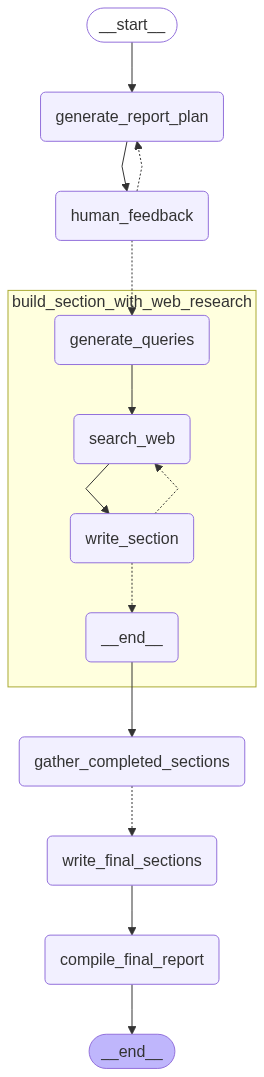

In [10]:
# Visualize the graph structure
# This shows the nodes and edges in the research workflow

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Helper function to set environment variables for API keys
# This ensures all necessary credentials are available for various services

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set the API keys used for any model or search tool selections below, such as:
_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("PERPLEXITY_API_KEY")

In [12]:
# Define report structure template and configure the research workflow
# This sets parameters for models, search tools, and report organization
from src.open_deep_research.intelligent_research import ResearchMode

REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report"""

# Configuration option 1: Claude 3.7 Sonnet for planning with perplexity search
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "perplexity",
                           "planner_provider": "google_genai",
                           "planner_model": "gemini-2.5-pro",
                           # "planner_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "writer_provider": "google_genai",
                           "writer_model": "gemini-2.5-flash",
                           # "writer_model_kwargs": {"temperature":0.8}, # if set custom parameters
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           }}

# Configuration option 2: DeepSeek-R1-Distill-Llama-70B for planning and llama-3.3-70b-versatile for writing
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "planner_model": "deepseek-r1-distill-llama-70b",
                           "writer_provider": "groq",
                           "writer_model": "llama-3.3-70b-versatile",
                           "report_structure": REPORT_STRUCTURE,
                           "max_search_depth": 1,}
                           }

# Configuration option 3: Use gemini flash for both planning and writing (selected option)
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "google_genai",
                           "planner_model": "gemini-2.5-pro-preview-05-06",
                           "writer_provider": "google_genai",
                           "writer_model": "gemini-2.5-flash",
                           "max_search_depth": 2,
                           "report_structure": REPORT_STRUCTURE,
                           "research_mode": ResearchMode.REFLECTIVE.value, # 🧠 Enable intelligent reflection
                           }}

# Define research topic about Model Context Protocol
topic = "Overview of Model Context Protocol (MCP), an Anthropic‑backed open standard for integrating external context and tools with LLMs. Give an architectural overview for developers, tell me about interesting MCP servers, and compare to google Agent2Agent (A2A) protocol."

# Run the graph workflow until first interruption (waiting for user feedback)
# 解决方案1: 使用标准的异步执行方式
import asyncio
import nest_asyncio

# 确保在Jupyter环境中支持嵌套事件循环
nest_asyncio.apply()

async def run_workflow_step():
    """运行工作流的第一步"""
    async for event in graph.astream({"topic": topic}, thread, stream_mode="updates"):
        if '__interrupt__' in event:
            interrupt_value = event['__interrupt__'][0].value
            display(Markdown(interrupt_value))
            break
        print(f"Event: {event}")

# 运行异步函数
await run_workflow_step()

Event: {'generate_report_plan': {'sections': [Section(name='Introduction', description='Brief overview of Model Context Protocol (MCP) and its significance in integrating external context and tools with Large Language Models (LLMs).', research=False, content=''), Section(name='MCP Architectural Overview for Developers', description="Detailed explanation of the Model Context Protocol (MCP) client-host-server architecture, its core components (Host, Clients, Servers), key design principles (e.g., server composability, security boundaries), and the capability negotiation process between clients and servers. This section is aimed at developers seeking to understand MCP's foundational structure.", research=True, content=''), Section(name='Exploring MCP Servers and Implementations', description='Overview of MCP server functionalities, detailing how they expose tools, resources, and prompts. Discussion of notable or interesting MCP server implementations and use cases, such as custom-built se

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Brief overview of Model Context Protocol (MCP) and its significance in integrating external context and tools with Large Language Models (LLMs).
Research needed: No


Section: MCP Architectural Overview for Developers
Description: Detailed explanation of the Model Context Protocol (MCP) client-host-server architecture, its core components (Host, Clients, Servers), key design principles (e.g., server composability, security boundaries), and the capability negotiation process between clients and servers. This section is aimed at developers seeking to understand MCP's foundational structure.
Research needed: Yes


Section: Exploring MCP Servers and Implementations
Description: Overview of MCP server functionalities, detailing how they expose tools, resources, and prompts. Discussion of notable or interesting MCP server implementations and use cases, such as custom-built servers (e.g., for specific business logic like a math server) or existing ecosystems like Azure AI Foundry, including examples of multi-server MCP architectures.
Research needed: Yes


Section: MCP vs. Google Agent2Agent (A2A) Protocol
Description: A comparative analysis of Model Context Protocol (MCP) and Google's Agent2Agent (A2A) protocol. This section will cover their respective purposes (MCP for agent-to-tool, A2A for agent-to-agent), architectural differences, key features, and typical use cases, highlighting how they might complement each other in complex AI systems.
Research needed: Yes


Section: Conclusion
Description: A concise summary of the report, highlighting the key aspects of MCP's architecture, server capabilities, and its distinct characteristics when compared to the A2A protocol. This section will include a table comparing MCP and A2A across key dimensions discussed in the report.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

# User Feedback Phase

* This allows for providing directed feedback on the initial report plan
* The user can review the proposed report structure and provide specific guidance
* The system will incorporate this feedback into the final report plan

In [13]:
# Submit feedback on the report plan
# The system will continue execution with the updated requirements

# Provide specific feedback to focus and refine the report structure
async def submit_feedback():
    """提交反馈并继续工作流"""
    async for event in graph.astream(Command(resume="Looks great! Just do one section related to Agent2Agent (A2A) protocol, introducing it and comparing to MCP."), thread, stream_mode="updates"):
        if '__interrupt__' in event:
            interrupt_value = event['__interrupt__'][0].value
            display(Markdown(interrupt_value))
            break
        print(f"Event: {event}")

# 运行反馈提交
await submit_feedback()

Event: {'human_feedback': {'feedback_on_report_plan': ['Looks great! Just do one section related to Agent2Agent (A2A) protocol, introducing it and comparing to MCP.']}}
Event: {'generate_report_plan': {'sections': [Section(name='Introduction', description='Brief overview of the Model Context Protocol (MCP) and its significance in integrating external context and tools with LLMs.', research=False, content=''), Section(name='Model Context Protocol (MCP): Architectural Overview for Developers', description='Detailed architectural overview of MCP for developers, including its core components (Hosts, Clients, Servers), design principles, communication mechanisms (JSON-RPC, transports), and key capabilities like resources, tools, prompts, and sampling. Include how MCP connects clients, servers, and LLMs.', research=True, content=''), Section(name='Exploring MCP: Interesting Servers and Use Cases', description='Exploration of interesting and notable MCP servers, including official examples an

Please provide feedback on the following report plan. 
                        

Section: Introduction
Description: Brief overview of the Model Context Protocol (MCP) and its significance in integrating external context and tools with LLMs.
Research needed: No


Section: Model Context Protocol (MCP): Architectural Overview for Developers
Description: Detailed architectural overview of MCP for developers, including its core components (Hosts, Clients, Servers), design principles, communication mechanisms (JSON-RPC, transports), and key capabilities like resources, tools, prompts, and sampling. Include how MCP connects clients, servers, and LLMs.
Research needed: Yes


Section: Exploring MCP: Interesting Servers and Use Cases
Description: Exploration of interesting and notable MCP servers, including official examples and community contributions. Discuss their functionalities and potential use cases in real-world applications (e.g., servers for databases, APIs, file systems, enterprise systems like Google Drive, Slack, GitHub).
Research needed: Yes


Section: MCP and Google Agent2Agent (A2A) Protocol: A Comparative Overview
Description: Introduction to Google's Agent2Agent (A2A) protocol, its purpose, and architecture. Comparative analysis of MCP and A2A, highlighting their primary goals (tool/context integration vs. inter-agent communication), key technical differences, use cases, and how they can be complementary.
Research needed: Yes


Section: Conclusion
Description: Concise summary of the report, distilling the main body sections. This will include a table or list comparing key aspects of MCP architecture, its server ecosystem, and its relation to A2A.
Research needed: No


                        
Does the report plan meet your needs?
Pass 'true' to approve the report plan.
Or, provide feedback to regenerate the report plan:

# Final Approval Phase
* After incorporating feedback, approve the plan to start content generation

In [15]:
# Approve the final plan and execute the report generation
# This triggers the research and writing phases for all sections

# The system will now:
# 1. Research each section topic
# 2. Generate content with citations
# 3. Create introduction and conclusion
# 4. Compile the final report

async def execute_final_report():
    """执行最终报告生成"""
    async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
        print(event)
        print("\n")

# 运行最终报告生成
await execute_final_report()

{'human_feedback': None}


{'build_section_with_web_research': {'completed_sections': [Section(name='Model Context Protocol (MCP): Architectural Overview for Developers', description='Detailed architectural overview of MCP for developers, including its core components (Hosts, Clients, Servers), design principles, communication mechanisms (JSON-RPC, transports), and key capabilities like resources, tools, prompts, and sampling. Include how MCP connects clients, servers, and LLMs.', research=True, content="## Model Context Protocol (MCP): Architectural Overview for Developers\n\nThe Model Context Protocol (MCP) employs a client-server architecture to integrate Large Language Models (LLMs) with external context and tools [1]. Hosts, such as LLM applications or Integrated Development Environments (IDEs), initiate connections and contain MCP Clients. Each Client maintains a one-to-one, stateful connection with an MCP Server, which provides capabilities like resources, tools, and prompts [1,

In [16]:
# Display the final generated report
# Retrieve the completed report from the graph's state and format it for display

final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Overview of Model Context Protocol (MCP)

The Model Context Protocol (MCP) is an Anthropic-backed open standard designed to seamlessly integrate Large Language Models (LLMs) with external context and tools. This report provides a comprehensive architectural overview for developers, detailing its client-server design and communication mechanisms. We explore interesting MCP servers, from official examples like Filesystem and Fetch to company-backed integrations, showcasing their diverse real-world applications. Finally, the report compares MCP with Google's Agent2Agent (A2A) protocol, highlighting their distinct yet complementary roles in the evolving AI ecosystem.

## Model Context Protocol (MCP): Architectural Overview for Developers

The Model Context Protocol (MCP) employs a client-server architecture to integrate Large Language Models (LLMs) with external context and tools [1]. Hosts, such as LLM applications or Integrated Development Environments (IDEs), initiate connections and contain MCP Clients. Each Client maintains a one-to-one, stateful connection with an MCP Server, which provides capabilities like resources, tools, and prompts [1, 3, 5]. This modular design aims to simplify AI integrations by allowing servers to focus on specific functionalities [5].

Communication between clients and servers adheres to the JSON-RPC 2.0 specification, ensuring structured message exchange via requests, responses, and one-way notifications [2, 4]. MCP is transport-agnostic, supporting Standard Input/Output (STDIO) for local processes and HTTP streaming (e.g., Server-Sent Events) or WebSockets for remote communication [1, 4].

Key capabilities exposed by servers include: **Resources**, representing contextual data; **Tools**, which are executable functions LLMs can invoke; and **Prompts**, predefined user-controlled templates [3, 5]. Additionally, MCP supports **Sampling**, a client-side feature enabling servers to request LLM completions through the client, with user oversight [7, 9]. The connection lifecycle involves an initialization handshake where client and server negotiate capabilities, followed by message exchange [1, 4].

### Sources
[1] Core architecture - Model Context Protocol: https://modelcontextprotocol.io/docs/concepts/architecture
[2] Specification - Model Context Protocol: https://spec.modelcontextprotocol.io/specification/2025-03-26/basic/
[3] A Practical Guide to the Model Context Protocol (MCP) for Large ...: https://artificialintelligenceschool.com/model-context-protocol-mcp-guide/
[4] MCP - Protocol Mechanics and Architecture | Pradeep Loganathan's Blog: https://pradeepl.com/blog/model-context-protocol/mcp-protocol-mechanics-and-architecture/
[5] The Model Context Protocol (MCP) — A Complete Tutorial: https://medium.com/@nimritakoul01/the-model-context-protocol-mcp-a-complete-tutorial-a3abe8a7f4ef
[6] Specification - Model Context Protocol: https://spec.modelcontextprotocol.io/specification/draft/client/sampling/
[7] Sampling - Model Context Protocol （MCP）: https://modelcontextprotocol.info/docs/concepts/sampling/
[8] Sampling - Model Context Protocol: https://modelcontextprotocol.io/docs/concepts/sampling
[9] MCP Sampling Explained: Adding Intelligence to Your MCP Servers: https://www.mcpevals.io/blog/mcp-sampling-explained

## Exploring MCP: Interesting Servers and Use Cases

Model Context Protocol (MCP) servers enable Large Language Models (LLMs) to securely interact with diverse external data sources and tools [1, 2, 3]. These servers are categorized into official reference implementations, company-maintained integrations, and community contributions, showcasing the protocol's versatility [1, 2, 4, 5].

Official reference servers demonstrate core MCP features. Current examples include Filesystem for secure file operations, Fetch for web content, and Memory for persistent knowledge graphs [1, 2, 5]. Archived reference servers previously supported integrations for Git, GitHub, Google Drive, PostgreSQL, SQLite, and Slack [1, 2, 5].

Company-backed integrations are notable, such as the MCP Toolbox for Databases [4, 5], Alibaba Cloud's DataWorks [4, 5], and financial trading platform Alpaca [4, 5]. Other official examples include Notion, PayPal, dbt, and GitHub's own server [4, 5]. Community-developed servers, like the FastAPI MCP for wrapping REST APIs, further extend capabilities [1, 2, 3, 4, 5]. This broad ecosystem facilitates real-world applications across databases, APIs, file systems, and enterprise systems [1, 2, 3, 4, 5].

### Sources
[1] MCP Examples - Model Context Protocol （MCP）: https://modelcontextprotocol.info/docs/examples/
[2] Example Servers - Model Context Protocol: https://modelcontextprotocol.io/examples
[3] Deep Dive into Public MCP Servers (with FastAPI & GitHub MCP Examples): https://mihirinamdar.medium.com/deep-dive-into-public-mcp-servers-with-fastapi-github-mcp-examples-b019c9b8b7f0
[4] Awesome MCP Servers: https://mcpservers.org/
[5] Model Context Protocol servers - GitHub: https://github.com/modelcontextprotocol/servers
[6] Top 10 integration patterns for enterprise use cases: https://blogs.mulesoft.com/api-integration/patterns/top-10-integration-patterns/
[7] Real-World ERP Examples: Success Stories and Lessons - Gestisoft: https://www.gestisoft.com/en/blog/unlocking-success-real-world-erp-systems-examples-and-lessons-learned
[8] 10 Successful ERP Implementation Examples - CMI: https://changemanagementinsight.com/successful-erp-implementation-examples/
[9] PDF: https://info.microsoft.com/rs/157-GQE-382/images/CO-AABD-CNTNT-FY18-03Mar-20-Azure-Databricks-Use-Cases-eBook.pdf
[10] 3 Successful ERP Implementation Case Studies - NetSuite: https://www.netsuite.com/portal/resource/articles/erp/erp-implementation-case-study.shtml

## MCP and Google Agent2Agent (A2A) Protocol: A Comparative Overview

Google's Agent2Agent (A2A) protocol, initiated by Google and its partners, is an open standard enabling communication and interoperability between diverse AI agents [1, 3, 5, 6]. Its agent-centric design allows agents to discover capabilities via "Agent Cards" and collaborate on tasks like delegation and context sharing, fostering a multi-agent ecosystem [1, 3, 4, 6, 9]. A2A uses standard web protocols such as HTTP/JSON-RPC 2.0 [3, 4, 6].

While both A2A and Anthropic's Model Context Protocol (MCP) enhance AI interoperability, they address distinct needs [3, 6, 7]. MCP, often called the "USB-C for AI," focuses on "vertical integration," connecting AI models to external tools and data sources for real-time context and actions [3, 6, 8]. This resource-centric protocol utilizes JSON-RPC 2.0 over transports like stdio or Streamable HTTP [1, 4, 9]. A2A, conversely, focuses on "horizontal integration," enabling agent-to-agent communication and coordination with stateful conversations [3, 6, 7, 8].

Google explicitly positions A2A as complementary to MCP, stating that combining them unlocks true agentic AI [1, 3, 6, 7]. An A2A agent might delegate a task to another agent, which then uses MCP to interact with external tools or data sources [4, 6, 7]. This synergy orchestrates multi-agent collaboration via A2A, while MCP provides individual agents with essential tool and data access [3, 7, 8].

### Sources

[1] Protocol Introduction - Agent2Agent Protocol - The A2A Protocol Community: https://agent2agent.info/docs/introduction/
[2] google/A2A | DeepWiki: https://deepwiki.com/google/A2A
[3] Comprehensive Research on Google’s Agent2Agent(A2A) Protocol and ...: https://kingy.ai/blog/comprehensive-research-on-googles-agent2agenta2a-protocol-and-competing-protocols/
[4] Agent2Agent (A2A) Protocol Specification - google-a2a.github.io: https://google-a2a.github.io/A2A/specification/
[5] GitHub - google-a2a/A2A: An open protocol enabling communication and ...: https://github.com/google-a2a/A2A
[6] A2A vs MCP: The Guide to AI Agent Protocols in 2025: https://aimojo.io/a2a-vs-mcp/
[7] A2A and MCP - Agent2Agent Protocol (A2A) - google-a2a.github.io: https://google-a2a.github.io/A2A/0.2.2/topics/a2a-and-mcp/
[8] MCP vs A2A: Comprehensive Comparison of AI Agent Protocols: https://medium.com/@neo-cruz/mcp-vs-a2a-comprehensive-comparison-of-ai-agent-protocols-862a969bac47
[9] A2A vs MCP: A Comprehensive Protocol Comparison: https://dev.to/vishalmysore/a2a-vs-mcp-a-comprehensive-protocol-comparison-4o26
[10] A2A vs MCP: Understanding the Difference | A2A Protocol Documentation: https://a2aprotocol.ai/docs/guide/a2a-vs-mcp

## Conclusion

The Model Context Protocol (MCP) provides a robust client-server architecture, enabling Large Language Models (LLMs) to seamlessly integrate with external context and tools. Its design, leveraging JSON-RPC over various transports like STDIO or HTTP streaming, allows servers to expose capabilities such as resources, executable tools, and predefined prompts. The vibrant MCP ecosystem includes official examples like Filesystem and Fetch, as well as company-backed integrations for databases and enterprise systems like GitHub. While MCP focuses on this "vertical integration"—connecting LLMs to external data—Google's Agent2Agent (A2A) protocol addresses "horizontal integration," facilitating communication and coordination between diverse AI agents. Both protocols are complementary, with A2A agents able to leverage MCP for critical tool and data access, paving the way for sophisticated, collaborative AI systems.

| Feature                     | Model Context Protocol (MCP)                       | Google Agent2Agent (A2A)                           |
| :-------------------------- | :------------------------------------------------- | :------------------------------------------------- |
| **Primary Goal**            | LLM integration with external tools/data           | Inter-AI agent communication and collaboration     |
| **Integration Type**        | Vertical (LLM to external systems)                 | Horizontal (AI agent to AI agent)                  |
| **Communication Mechanism** | JSON-RPC 2.0 (transport-agnostic: stdio, HTTP)     | JSON-RPC 2.0 (over standard web protocols like HTTP) |

Trace: 

> Note: uses 80k tokens 

https://smith.langchain.com/public/31eca7c9-beae-42a3-bef4-5bce9488d7be/r